In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModelTimeStep
from deep_macrofin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, OptimizerType, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    # constants
    r"\gamma^i": "gammai",
    r"\gamma^h": "gammah",
    r"\rho^i": "rhoi",
    r"\rho^h": "rhoh",
    r"\sigma^a": "siga",
    r"\sigma^{a}": "siga",
    r"\mu^a": "mua",
    r"\mu^O": "muO",
    r"\zeta^i": "zetai",
    r"\zeta^h": "zetah",
    r"\alpha^a": "aa",
    r"\kappa": "kappa",

    # state variables
    r"\eta_t": "eta",

    # learnable variables (agents + endogenous variables)
    r"\xi_t^i": "xii",
    r"\xi_t^h": "xih",
    r"\mu_t^{\eta}": "mue",
    r"\sigma_t^{\eta a}": "sigea",
    r"q_t^a": "qa",
    r"w_t^{ia}": "wia",
    r"w_t^{ha}": "wha",

    # variables defined by equations
    r"\iota_t^a": "iota_a",
    r"\Phi_t^a": "phi_a",
    r"c_t^i": "ci",
    r"c_t^h": "ch",
    r"\sigma^{qa}": "sigqa",
    r"\sigma_t^{qa}": "sigqa",
    r"\sigma_t^{nia}": "signia",
    r"\sigma_t^{nha}": "signha",
    r"\sigma_t^{\xi ia}": "sigxia",
    r"\sigma_t^{\xi ha}": "sigxha",
    r"\sigma_t^{na}": "signa",
    r"\mu_t^{qa}": "muqa",
    r"\hat{r_t^{ka}}": "rka_hat", # define hat first, and replace hat first
    r"r_t^{ka}": "rka",
    r"\mu_t^{ni}": "muni",
    r"\mu_t^{nh}": "munh",
    r"\mu_t^{\xi i}": "muxi",
    r"\mu_t^{\xi h}": "muxh",
}

In [3]:
set_seeds(0)
pde_model = PDEModelTimeStep("problem1", {"num_outer_iterations": 10, "num_inner_iterations": 2000}, latex_var_mapping)
pde_model.set_state(["eta"], {"eta": [0.01, 0.99]})
pde_model.add_agents(["xii", "xih"], {"xii": {"positive": True}, "xih": {"positive": True}})
pde_model.add_endogs(["mue", "qa", "wia", "wha", "sigea"], {"qa": {"positive": True}})
pde_model.add_params({
    "gammai": 2.0,
    "gammah": 5.0,
    "rhoi": 0.05,
    "rhoh": 0.05,
    "siga": 0.2, #\sigma^{a}
    "mua": 0.04,
    "muO": 0.04,
    "zetai":1.00005,
    "zetah":1.00005,
    "aa":0.1,
    "kappa":10000
})
pde_model.add_equation(r"$\iota_t^a = \frac{q_t^a - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi_t^a = \frac{1}{\kappa} * \log(1+\kappa * \iota_t^a)$")
pde_model.add_equation(r"$c_t^i = (\rho^i)^{\zeta^i} * (\xi_t^i)^{1-\zeta^i}$")
pde_model.add_equation(r"$c_t^h = (\rho^h)^{\zeta^h} * (\xi_t^h)^{1-\zeta^h}$")
pde_model.add_equation(r"$\sigma_t^{qa} = \frac{1}{q_t^a}  * \frac{\partial q_t^a}{\partial \eta_t}  * \sigma_t^{\eta a}  * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{nia} = w_t^{ia}*(\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\sigma_t^{nha} = w_t^{ha}*(\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\sigma_t^{\xi ia}  = \frac{1}{\xi_t^i} * \frac{\partial \xi_t^i}{\partial \eta_t} * \sigma_t^{\eta a} * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{\xi ha}  = \frac{1}{\xi_t^h} * \frac{\partial \xi_t^h}{\partial \eta_t} * \sigma_t^{\eta a} * \eta_t$")
pde_model.add_equation(r"$\sigma_t^{na} = \eta_t * \sigma_t^{nia} + (1-\eta_t) * \sigma_t^{nha}$")
pde_model.add_equation(r"$\mu_t^{qa} = \frac{1}{q_t^a}  * \left(\frac{\partial q_t^a}{\partial \eta_t}  * \mu_t^{\eta}  * \eta_t + \frac{1}{2}  * \frac{\partial^2 q_t^a}{\partial \eta_t^2}  * (\sigma_t^{\eta a}  * \eta_t)^2\right)$")
pde_model.add_equation(r"$r_t^{ka} = \mu_t^{qa} + \mu^a + \Phi_t^a + \sigma^a * \sigma^{qa} + \frac{\alpha^a - \iota_t^a}{q_t^a}$")
pde_model.add_equation(r"$r_t = r_t^{ka} - \gamma^h * w_t^{ha} * (\sigma^a + \sigma_t^{qa})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * (\sigma^a + \sigma_t^{qa})$")
pde_model.add_equation(r"$\mu_t^{ni} = r_t - c_t^i + w_t^{ia} * (r_t^{ka} - r_t)$")
pde_model.add_equation(r"$\mu_t^{nh} = r_t - c_t^h + w_t^{ha} * (r_t^{ka} - r_t)$")
pde_model.add_equation(r"$\mu_t^{\xi i} &= - \frac{\rho^i}{1-\frac{1}{\zeta^i}} * \left( \left(\frac{c_t^i}{\xi_t^i} \right)^{1-1/\zeta^i}-1 \right) - \mu_t^{ni} + \frac{\gamma^i}{2} * (\sigma_t^{nia})^2  + \frac{\gamma^i}{2} * (\sigma_t^{\xi ia})^2 - (1-\gamma^i) * \sigma_t^{\xi ia} * \sigma_t^{nia}$")
pde_model.add_equation(r"$\mu_t^{\xi h} &= - \frac{\rho^h}{1-\frac{1}{\zeta^h}} * \left( \left(\frac{c_t^h}{\xi_t^h} \right)^{1-1/\zeta^h}-1 \right) - \mu_t^{nh} + \frac{\gamma^h}{2} * (\sigma_t^{nha})^2  + \frac{\gamma^h}{2} * (\sigma_t^{\xi ha})^2 - (1-\gamma^h) * \sigma_t^{\xi ha} * \sigma_t^{nha}$")
pde_model.add_equation(r"$\hat{r_t^{ka}} = r_t^{ka} + \frac{\mu^O - \mu^a}{\sigma^a} * (\sigma^a + \sigma_t^{qa})$")

pde_model.add_endog_equation(r"$\mu_t^{\eta} = (1-\eta_t) * (\mu_t^{ni} - \mu_t^{nh}) +(\sigma_t^{na})^2  - \sigma_t^{nia} * \sigma_t^{na}$")
pde_model.add_endog_equation(r"$\sigma_t^{\eta a} = (1-\eta_t) * (\sigma_t^{nia} - \sigma_t^{nha})$")
pde_model.add_endog_equation(r"$\hat{r_t^{ka}} - r_t = \gamma^i * w_t^{ia} * (\sigma^a  + \sigma_t^{qa})^2 - (1-\gamma^i) * \sigma_t^{\xi ia} * (\sigma^{a}  + \sigma_t^{qa})$")
# pde_model.add_endog_equation(r"$r_t^{ka} - r_t = \gamma^h * w_t^{ha} * (\sigma^a  + \sigma_t^{qa})^2 + (1-\gamma^h) * \sigma_t^{\xi ha} * (\sigma^{a}  + \sigma_t^{qa})$")
pde_model.add_endog_equation(r"$1 = w_t^{ia} * \eta_t + w_t^{ha} * (1-\eta_t)$")
pde_model.add_endog_equation(r"$\alpha^a - \iota_t^a = (c_t^i*\eta_t + c_t^h * (1 - \eta_t)) * q_t^a$")

pde_model.add_hjb_equation(r"$\frac{\partial \xi_t^i}{\partial t} + \frac{\partial \xi_t^i}{\partial \eta_t} * \mu_t^{\eta} * \eta_t + \frac{1}{2} * \frac{\partial^2 \xi_t^i}{\partial \eta_t^2} * (\sigma_t^{\eta a} * \eta_t)^2 - \mu_t^{\xi i} * \xi_t^i$")
pde_model.add_hjb_equation(r"$\frac{\partial \xi_t^h}{\partial t} + \frac{\partial \xi_t^h}{\partial \eta_t} * \mu_t^{\eta} * \eta_t + \frac{1}{2} * \frac{\partial^2 \xi_t^h}{\partial \eta_t^2} * (\sigma_t^{\eta a} * \eta_t)^2 - \mu_t^{\xi h} * \xi_t^h$")

print(pde_model)
if not os.path.exists("./models/1d_prob/model.pt"):
    pde_model.train_model("./models/1d_prob", "model.pt", True)
    pde_model.load_model(torch.load("./models/1d_prob/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/1d_prob/model_best.pt"))
    pde_model.eval_model(True)

===========================Summary of Model problem1============================
Config: {
 "batch_size": 100,
 "num_outer_iterations": 10,
 "num_inner_iterations": 2000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001
}
Latex Variable Mapping:
{
 "\\gamma^i": "gammai",
 "\\gamma^h": "gammah",
 "\\rho^i": "rhoi",
 "\\rho^h": "rhoh",
 "\\sigma^a": "siga",
 "\\sigma^{a}": "siga",
 "\\mu^a": "mua",
 "\\mu^O": "muO",
 "\\zeta^i": "zetai",
 "\\zeta^h": "zetah",
 "\\alpha^a": "aa",
 "\\kappa": "kappa",
 "\\eta_t": "eta",
 "\\xi_t^i": "xii",
 "\\xi_t^h": "xih",
 "\\mu_t^{\\eta}": "mue",
 "\\sigma_t^{\\eta a}": "sigea",
 "q_t^a": "qa",
 "w_t^{ia}": "wia",
 "w_t^{ha}": "wha",
 "\\iota_t^a": "iota_a",
 "\\Phi_t^a": "phi_a",
 "c_t^i": "ci",
 "c_t^h": "ch",
 "\\sigma^{qa}": "sigqa",
 "\\sigma_t^{qa}": "sigqa",
 "\\sigma_t^{nia}": "signia",
 "\\sigma_t^{nha}": "signha",
 "\\sigma_t^{\\xi ia}": "sigxia",
 "\\si

Total loss: 0.0287: 100%|██████████| 2000/2000 [02:57<00:00, 11.28it/s]
D:\Research\continuous-time-eco-models\deep_macrofin\pde_model_time_step.py:322: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Model loaded
xii: Absolute Change: 0.12197, Relative Change:  0.12197
xih: Absolute Change: 0.16789, Relative Change:  0.16789
mue: Absolute Change: 0.95557, Relative Change:  0.95557
qa: Absolute Change: 0.93382, Relative Change:  0.93382
wia: Absolute Change: 0.49262, Relative Change:  0.49262
wha: Absolute Change: 0.47103, Relative Change:  0.47103
sigea: Absolute Change: 0.90435, Relative Change:  0.90435
Outer Loop 0 Finished in 177.3570s. Loading best model...


Total loss: 0.0010: 100%|██████████| 1414/1414 [02:10<00:00, 10.82it/s]


Model loaded
xii: Absolute Change: 0.10327, Relative Change:  0.11768
xih: Absolute Change: 0.13244, Relative Change:  0.15939
mue: Absolute Change: 0.01362, Relative Change:  0.52893
qa: Absolute Change: 0.09090, Relative Change:  0.04907
wia: Absolute Change: 0.10144, Relative Change:  0.06597
wha: Absolute Change: 0.12822, Relative Change:  0.44242
sigea: Absolute Change: 0.02196, Relative Change:  0.36139
Outer Loop 1 Finished in 130.6273s. Loading best model...


Total loss: 0.0003: 100%|██████████| 1154/1154 [01:51<00:00, 10.31it/s]


Model loaded
xii: Absolute Change: 0.08531, Relative Change:  0.11044
xih: Absolute Change: 0.10867, Relative Change:  0.15564
mue: Absolute Change: 0.01722, Relative Change:  0.66694
qa: Absolute Change: 0.03722, Relative Change:  0.01843
wia: Absolute Change: 0.13262, Relative Change:  0.08459
wha: Absolute Change: 0.08163, Relative Change:  0.14357
sigea: Absolute Change: 0.03049, Relative Change:  6.25374
Outer Loop 2 Finished in 111.9036s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]


Model loaded
xii: Absolute Change: 0.07239, Relative Change:  0.10562
xih: Absolute Change: 0.08756, Relative Change:  0.14857
mue: Absolute Change: 0.00323, Relative Change:  0.20078
qa: Absolute Change: 0.02182, Relative Change:  0.01108
wia: Absolute Change: 0.02704, Relative Change:  0.01690
wha: Absolute Change: 0.03609, Relative Change:  0.08971
sigea: Absolute Change: 0.00749, Relative Change:  0.19266
Outer Loop 3 Finished in 89.0869s. Loading best model...


Total loss: 0.0000: 100%|██████████| 894/894 [01:30<00:00,  9.84it/s]


Model loaded
xii: Absolute Change: 0.06133, Relative Change:  0.10029
xih: Absolute Change: 0.07186, Relative Change:  0.14312
mue: Absolute Change: 0.00299, Relative Change:  0.04036
qa: Absolute Change: 0.00971, Relative Change:  0.00488
wia: Absolute Change: 0.03313, Relative Change:  0.01842
wha: Absolute Change: 0.01730, Relative Change:  0.03219
sigea: Absolute Change: 0.00779, Relative Change:  0.23743
Outer Loop 4 Finished in 90.8741s. Loading best model...


Total loss: 0.0000: 100%|██████████| 816/816 [01:15<00:00, 10.75it/s]


Model loaded
xii: Absolute Change: 0.05251, Relative Change:  0.09566
xih: Absolute Change: 0.05879, Relative Change:  0.13666
mue: Absolute Change: 0.00093, Relative Change:  0.02490
qa: Absolute Change: 0.00505, Relative Change:  0.00253
wia: Absolute Change: 0.00496, Relative Change:  0.00272
wha: Absolute Change: 0.00289, Relative Change:  0.00520
sigea: Absolute Change: 0.00140, Relative Change:  0.17673
Outer Loop 5 Finished in 75.9297s. Loading best model...


Total loss: 0.0000: 100%|██████████| 755/755 [01:03<00:00, 11.87it/s]


Model loaded
xii: Absolute Change: 0.04512, Relative Change:  0.09103
xih: Absolute Change: 0.04850, Relative Change:  0.13058
mue: Absolute Change: 0.00137, Relative Change:  0.03719
qa: Absolute Change: 0.00274, Relative Change:  0.00137
wia: Absolute Change: 0.01136, Relative Change:  0.00628
wha: Absolute Change: 0.00673, Relative Change:  0.01296
sigea: Absolute Change: 0.00232, Relative Change:  0.04991
Outer Loop 6 Finished in 63.6079s. Loading best model...


Total loss: 0.0000: 100%|██████████| 707/707 [01:11<00:00,  9.91it/s]


Model loaded
xii: Absolute Change: 0.03905, Relative Change:  0.08681
xih: Absolute Change: 0.04027, Relative Change:  0.12470
mue: Absolute Change: 0.00103, Relative Change:  0.02638
qa: Absolute Change: 0.00172, Relative Change:  0.00086
wia: Absolute Change: 0.00683, Relative Change:  0.00356
wha: Absolute Change: 0.00263, Relative Change:  0.00457
sigea: Absolute Change: 0.00138, Relative Change:  0.01578
Outer Loop 7 Finished in 71.3705s. Loading best model...


Total loss: 0.0000: 100%|██████████| 666/666 [01:03<00:00, 10.53it/s]


Model loaded
xii: Absolute Change: 0.03397, Relative Change:  0.08276
xih: Absolute Change: 0.03368, Relative Change:  0.11912
mue: Absolute Change: 0.00106, Relative Change:  0.02525
qa: Absolute Change: 0.00106, Relative Change:  0.00053
wia: Absolute Change: 0.00857, Relative Change:  0.00453
wha: Absolute Change: 0.00363, Relative Change:  0.00659
sigea: Absolute Change: 0.00164, Relative Change:  0.01044
Outer Loop 8 Finished in 63.2336s. Loading best model...


Total loss: 0.0000: 100%|██████████| 632/632 [00:56<00:00, 11.17it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_15596\1511432107.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Model loaded
xii: Absolute Change: 0.02970, Relative Change:  0.07894
xih: Absolute Change: 0.02834, Relative Change:  0.11377
mue: Absolute Change: 0.00095, Relative Change:  0.02700
qa: Absolute Change: 0.00061, Relative Change:  0.00030
wia: Absolute Change: 0.00714, Relative Change:  0.00373
wha: Absolute Change: 0.00297, Relative Change:  0.00536
sigea: Absolute Change: 0.00137, Relative Change:  0.01216
Outer Loop 9 Finished in 56.5785s. Loading best model...
training finished, total time :: 931.2681562900543
Best model saved to ./models/1d_prob/model_best.pt if valid
Model saved to ./models/1d_prob/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
endogeq_3: 0.0000,
endogeq_4: 0.0000,
endogeq_5: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_xii_cond_time_boundary: 0.0000,
agent_xih_cond_time_boundary: 0.0000,
endogvar_mue_cond_time_boundary: 0.0000,
endogvar_qa_cond_time_boundary

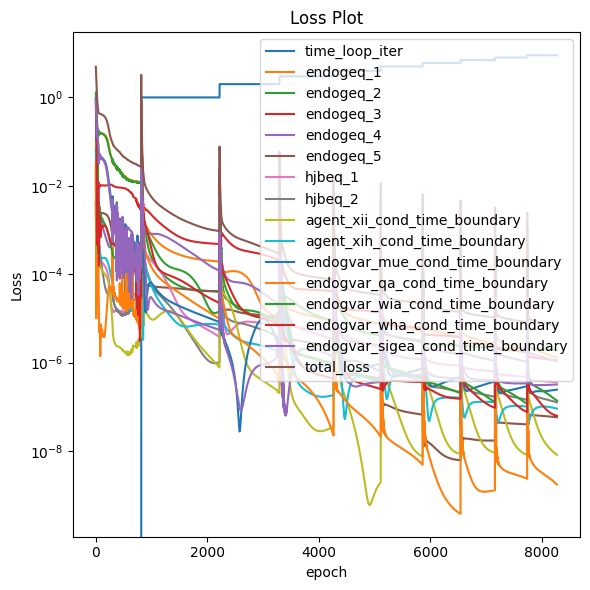

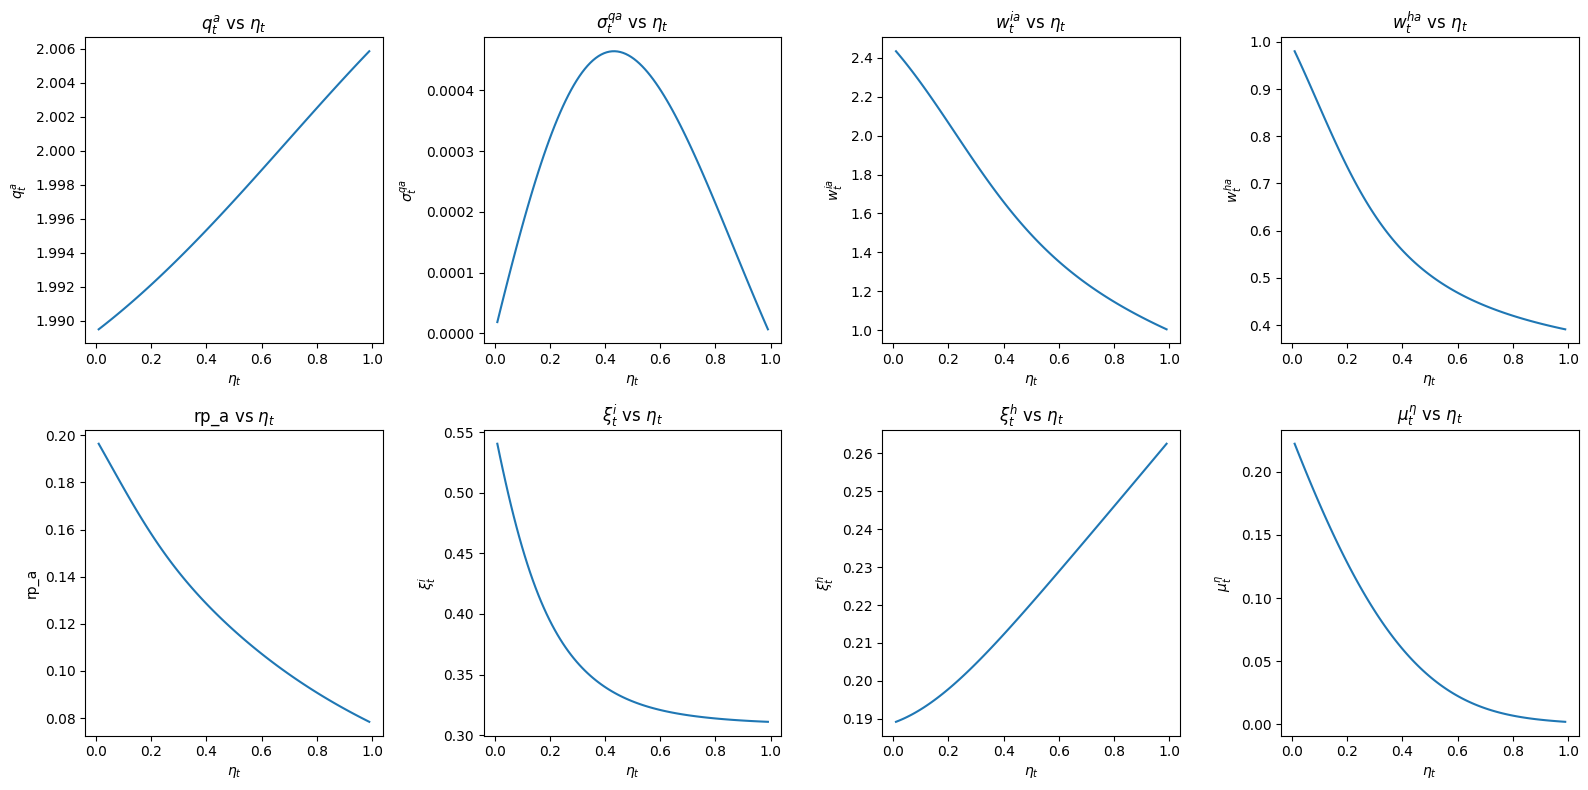

In [5]:
plot_loss_df(fn="./models/1d_prob/model_min_loss.csv", loss_plot_fn="./models/1d_prob/model_min_loss.png")
pde_model.plot_vars([r"$q_t^a$", r"$\sigma_t^{qa}$", r"$w_t^{ia}$", r"$w_t^{ha}$", "rp_a = rka-r_t", r"$\xi_t^i$", r"$\xi_t^h$", r"$\mu_t^{\eta}$"])